In [257]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

pd.options.mode.copy_on_write = True

In [258]:
def calc_total_emissions(df):
    gasses = ["Kohlendioxid (CO2)", "Methan (CH4)", "Distickstoffmonoxid (N2O)", "Flüchtige Kohlenwasserstoffe ohne Methan (NMVOC)", "Feinstaub (10 µm)"]
    new_cols = ["economic_sector"] + gasses
    analyzed_df = df[new_cols]
    analyzed_df["total_emissions"] = df[gasses].sum(axis=1)
    analyzed_df["excluded_emissions"] = calc_excluded_emissions(df, gasses)
    new_col_order = ["economic_sector", "total_emissions", "excluded_emissions"] + gasses
    analyzed_df = analyzed_df[new_col_order]
    analyzed_df = analyzed_df.sort_values(by="total_emissions", ascending=False)
    return analyzed_df

def calc_excluded_emissions(df, included_gasses):
    columns_to_remove = ["year", "economic_sector"] + included_gasses
    excluded_gasses = [col for col in df.columns if col not in columns_to_remove]
    return df[excluded_gasses].sum(axis=1)

def calc_proportions(df):
    # emission from all sectors, from only included 5 gasses
    total_year_emission = df["total_emissions"].sum()
    # emission from all sectors, from excluded gasses
    total_excluded_year_emission = df["excluded_emissions"].sum()
    # all of the emissions in a year, from all gasses
    total = total_year_emission + total_excluded_year_emission
    df["proportions"] = (df["total_emissions"] / total).round(2)
    df["excluded_proportions"] = (df["excluded_emissions"] / total).round(2)
    return total_year_emission

def add_others_sector(df, rank=6):
    num_sectors = len(df)
    others_df = df.tail(num_sectors - rank - 1)
    sums = others_df.drop(columns=["economic_sector"]).sum()
    others_row = pd.DataFrame(data={'economic_sector': ['Others'], **sums.to_dict()})
    df_with_others = pd.concat([df.head(rank-1), others_row], ignore_index=True)
    df_with_others = df_with_others.sort_values(by="total_emissions", ascending=False)
    return df_with_others


def analyze_year(year, rank=6):
    filename = f"../data/Luftemissionen_{year}.csv"
    df = pd.read_csv(filename, delimiter=";")
    smaller_df = calc_total_emissions(df)
    df_to_analyze = add_others_sector(smaller_df, rank)
    calc_proportions(df_to_analyze)
    return df_to_analyze



In [322]:
def visualize(df):
    sns.set_style("darkgrid")
    palette = sns.color_palette("cubehelix")
    catp = (sns.catplot(data=df, x='economic_sector', y='proportions',
                    kind='bar',
                    hue="economic_sector",
                    palette=palette,
                    height=5,
                    aspect=19/6))
        
    catp.set_axis_labels("Economic Sectors", "Proportion", fontsize=14)
    plt.title("\n".join(wrap("Proportional Contribution of Each Sector to Total Air Emissions", 90)), fontsize=18)
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))
    plt.tight_layout()
    catp.ax.set_yticks((0,0.10,0.20,0.30,0.40))

    for ax in catp.axes.ravel():
        labels = ax.get_xticklabels()
        for v in labels:
            text = v.get_text()
            text = '\n'.join(wrap(text, 30))
            v.set_text(text)
        ax.set_xticklabels(labels)
        for c in ax.containers:
            ax.bar_label(c, label_type='edge')


In [260]:
def get_total_emissions(df, sector_name):
    return df.loc[df['economic_sector'] == sector_name, 'total_emissions'].values[0]

In [352]:
def get_proportions_for_year(df_dict, year):
    df = df_dict[year].set_index('economic_sector')
    return df.reindex(sectors)['proportions']

def compare_two_years_by_sector(year_dict, year_1, year_2, sectors=["Energie und Dienstleistungen der Energieversorgung", "Private Haushalte", "Others", "Metalle"]):
    comparison_df = pd.DataFrame(index=sectors)
    year_1995 = year_dict[year_1].loc[year_dict[year_1]["economic_sector"].isin(sectors), "proportions"]
    year_2019 = year_dict[year_2].loc[year_dict[year_2]["economic_sector"].isin(sectors), "proportions"]
    comparison_df[year_1] = get_proportions_for_year(year_dict, year_1)
    comparison_df[year_2] = get_proportions_for_year(year_dict, year_2)
    comparison_df.reset_index(inplace=True)
    comparison_df.rename(columns={'index': 'economic_sectors'}, inplace=True)
    comparison_long_df = pd.melt(comparison_df, id_vars=['economic_sectors'], var_name='year', value_name='proportions')


    sns.set_style("darkgrid")
    palette = sns.color_palette("cubehelix")
    plt.tight_layout()
    catp = sns.catplot(data=comparison_long_df, kind="bar", x="economic_sectors", y="proportions", hue="year", 
                    height=6, aspect=16/9, palette=palette)

    catp.set_axis_labels("Sectors", "Proportions", fontsize=12)
    catp.fig.suptitle("Comparison between years", fontsize=16)
    catp.set_titles("{col_name}")

    for ax in catp.axes.ravel():
            labels = ax.get_xticklabels()
            for v in labels:
                text = v.get_text()
                text = '\n'.join(wrap(text, 30))
                v.set_text(text)
            ax.set_xticklabels(labels)
            for c in ax.containers:
                ax.bar_label(c, label_type='edge')


In [261]:
year_dict = {}
for i in range(1995, 2020):
    year_dict[i] = analyze_year(i, 10)

In [269]:
def visualize_trend(dict_of_df, sector_name, limit):
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))

    total_dict = {}
    
    for year in dict_of_df.keys():
        total = get_total_emissions(dict_of_df[year], sector_name)
        total_dict[year] = total

    plot_df = pd.DataFrame(list(total_dict.items()), columns=['year', 'total_emissions'])

    lineplot = sns.lineplot(data=plot_df, x="year", y="total_emissions", marker='o', color='b')
    plt.ylim(0, limit)
    lineplot.set_xlabel("Year", fontsize=12)
    lineplot.set_ylabel("Total Emissions", fontsize=12)
    lineplot.set_title("\n".join(wrap(f"Emission Trend for {sector_name}", 60)), fontsize=16)

    # Customize tick labels and rotation
    plt.xticks(list(dict_of_df.keys()), rotation=45)

    plt.tight_layout()
    plt.show()

    return total_dict

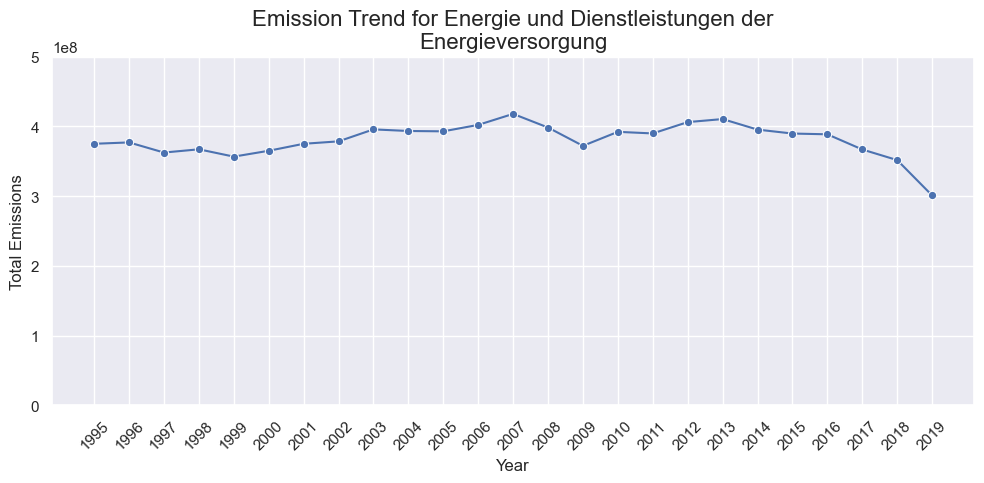

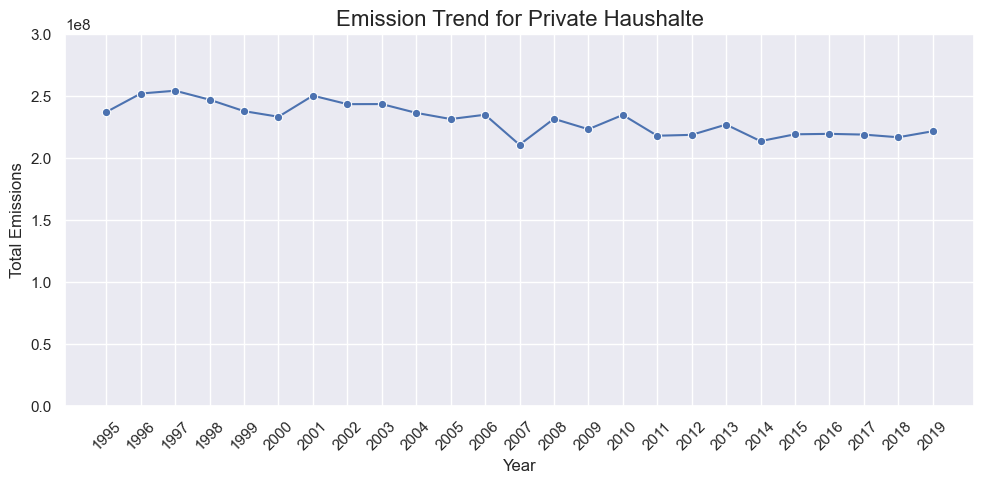

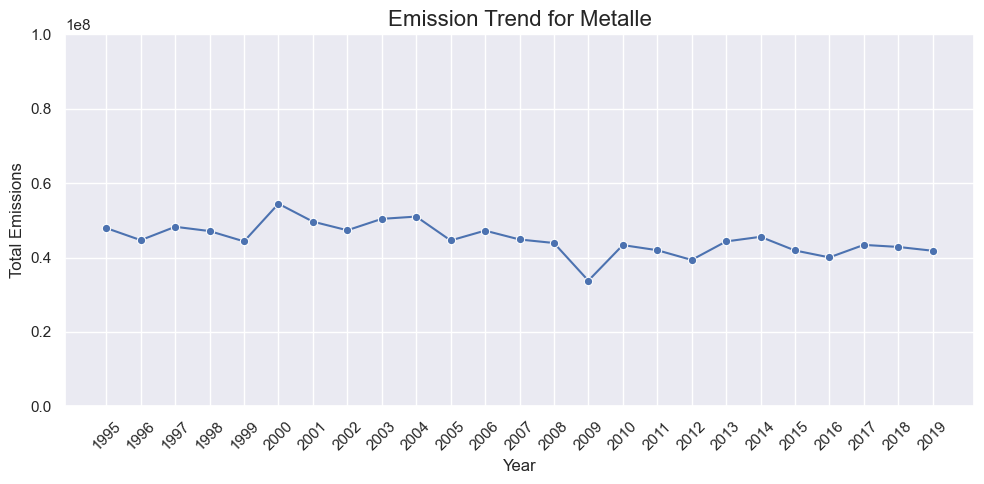

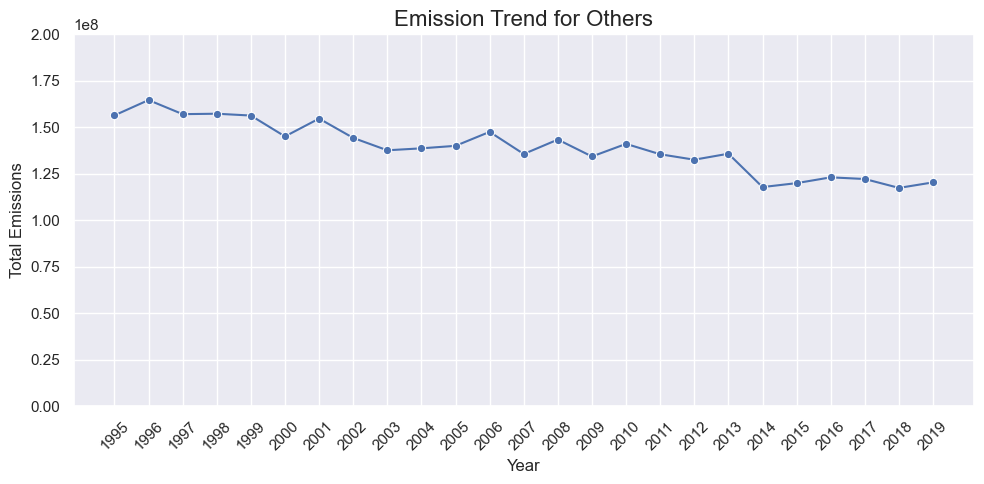

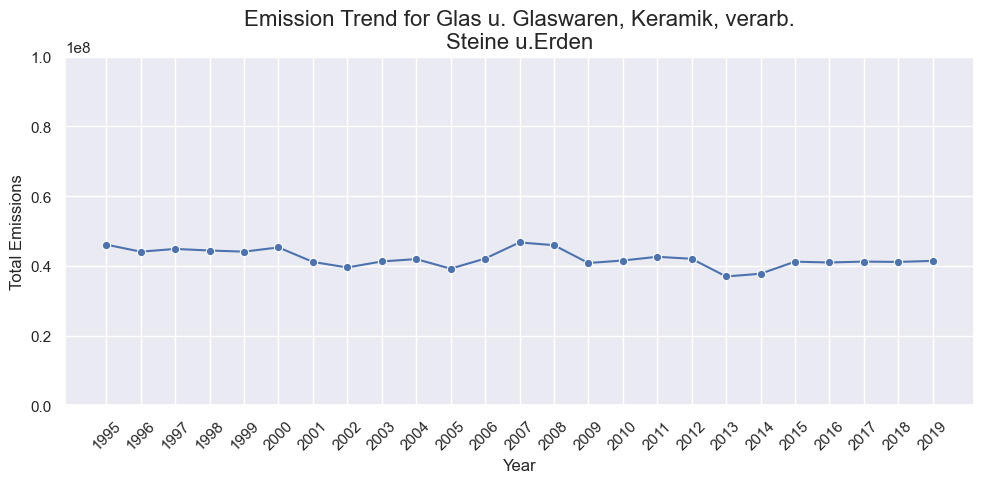

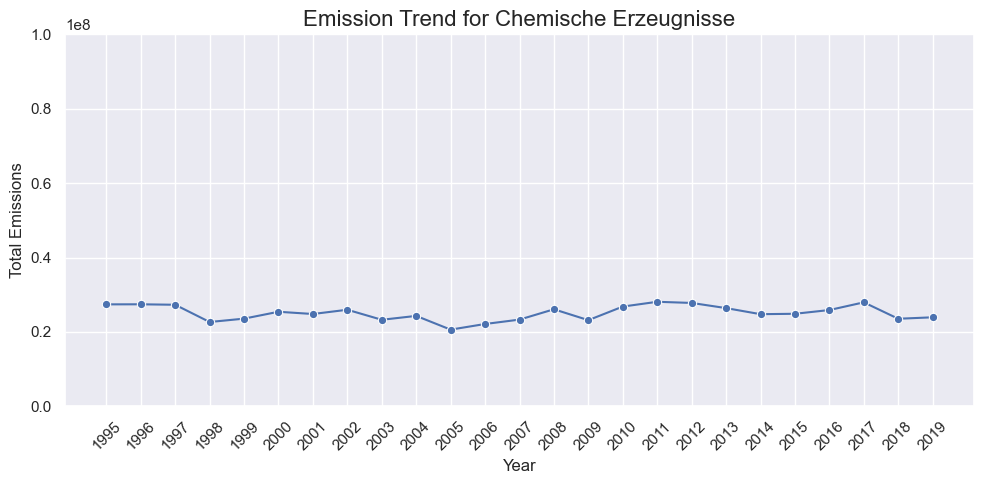

In [277]:
energy_comparison = visualize_trend(year_dict, "Energie und Dienstleistungen der Energieversorgung", limit=5e8)
private_hh_comparison = visualize_trend(year_dict, "Private Haushalte", limit=3e8)
metal_comparison = visualize_trend(year_dict, "Metalle", limit=1e8)
others_comparison = visualize_trend(year_dict, "Others", limit=2e8)
glass_comparison = visualize_trend(year_dict, "Glas u. Glaswaren, Keramik, verarb. Steine u.Erden", limit=1e8)
chemical_comparison = visualize_trend(year_dict, "Chemische Erzeugnisse", limit=1e8)

C:\Users\asude\AppData\Local\Temp\ipykernel_18896\376337324.py:19: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  catp = sns.catplot(data=comparison_long_df, kind="bar", x="economic_sectors", y="proportions", hue="year",
C:\Users\asude\AppData\Local\Temp\ipykernel_18896\376337324.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


<Figure size 640x480 with 0 Axes>

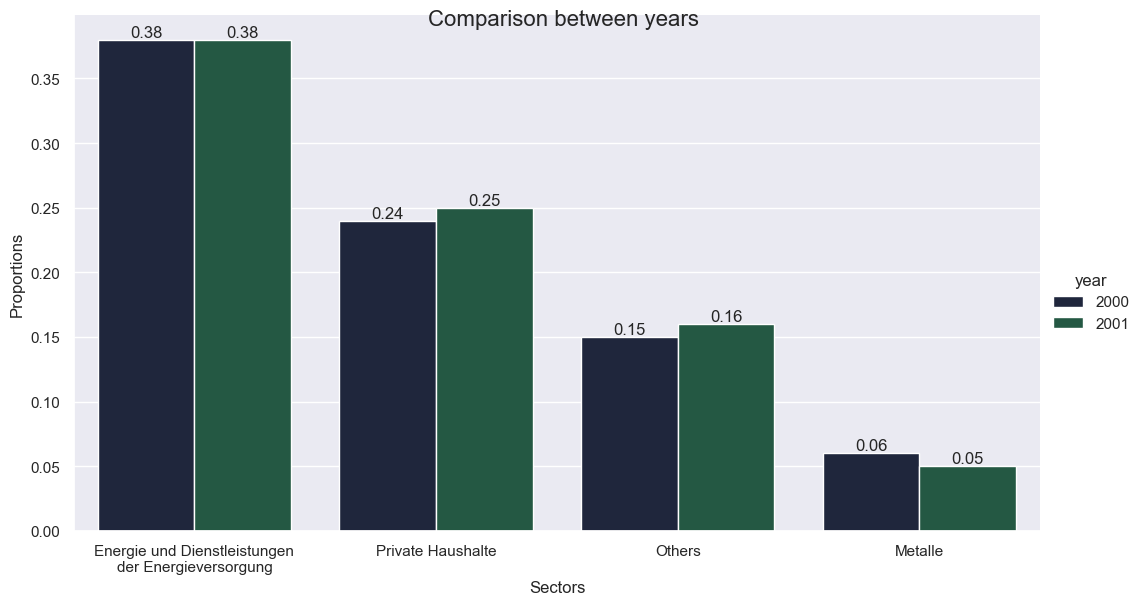

In [354]:
compare_two_years_by_sector(year_dict, 2000, 2001)